In [1]:
# Check RAM Memory

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')
  
print(ram_gb)

# Login into drive

from google.colab import drive
drive.mount('/content/drive')

# Importing "load_model"

from keras.models import load_model

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!
89.63678208
Mounted at /content/drive


In [2]:
import numpy as np
from tensorflow.keras import optimizers

# Download and import data preprocessing .py file
!wget https://raw.githubusercontent.com/DiSanchz/satellite_imagery_econ_indicators/main/satellite_imagery_econ_indicators/data_processing.py
from data_processing import data_bundle as data_bundle

# Download and import performance metrics .py file
!wget https://raw.githubusercontent.com/DiSanchz/satellite_imagery_econ_indicators/main/satellite_imagery_econ_indicators/performance_metrics.py
from performance_metrics import plot_ROC, plot_cm, plot_acc_loss
from sklearn.metrics import classification_report

# Download and import RN50 .py file
! wget https://raw.githubusercontent.com/DiSanchz/satellite_imagery_econ_indicators/main/satellite_imagery_econ_indicators/ResNet50.py
from ResNet50 import rn50_seei as rn50_class

# Download and import RN50 .py file

--2023-05-15 20:28:36--  https://raw.githubusercontent.com/DiSanchz/satellite_imagery_econ_indicators/main/satellite_imagery_econ_indicators/data_processing.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3955 (3.9K) [text/plain]
Saving to: ‘data_processing.py’

data_processing.py  100%[===================>]   3.86K  --.-KB/s    in 0s      

2023-05-15 20:28:36 (87.1 MB/s) - ‘data_processing.py’ saved [3955/3955]

--2023-05-15 20:28:37--  https://raw.githubusercontent.com/DiSanchz/satellite_imagery_econ_indicators/main/satellite_imagery_econ_indicators/performance_metrics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserconten

In [3]:
# Define relevant paths for appropriately instantiating the data_bundle class
images_path_0 = "/content/drive/MyDrive/Thesis/M224A-2111/inputs/images_224A_2111.npy"
popn_path_0 = "/content/drive/MyDrive/Thesis/M224A-2111/inputs/popn_224A_2111.npy"
target_var = "hdi"

# In this case GDP has been chose
if target_var == "gdp":
  labels_path_0 = "/content/drive/MyDrive/Thesis/M224A-2111/inputs/gdp_224A_2111.npy"
  label_type = "GDPpercap"

elif target_var == "hdi":
  labels_path_0 = "/content/drive/MyDrive/Thesis/M224A-2111/inputs/hdi_224A_2111.npy"
  label_type = "HDI"

# Instantiate data_bundle object
basic_bundle = data_bundle(images_path_0, popn_path_0, labels_path_0, label_type, augmented=True)

# Preprocess data through the data_bundle class' methods
basic_bundle.normalize_images()
basic_bundle.normalize_popn()
basic_bundle.bundle_inputs()
basic_bundle.split_data(0.4,0.5,2023)
basic_bundle.unbundle_and_shape_inputs()
basic_bundle.onehot_encode_labels()

# The resulting input sets are: self.X_tri, self.X_vai, self.X_tei (Images) and self.X_trp, self.X_vap, self.X_tep (Population)
# The resulting tragets are: self.y_train_onehot, self.y_val_onehot and self.y_test_onehot
# Where "self" is to be substituted by the given name to the data_bundle instance

/content/data_processing.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  features = np.array(list(zip(self.images, np.array(self.popn))))


### Model: ResNet50 - HDI

In [4]:
# Eliminar learning rate de vgg.py y pasar el dropout a argumento de método y no de clase
rn_model = rn50_class(input_shape=(224, 224, 3))

rn_model.load_and_freeze_rn50()
rn_model.enable_dual_input()
rn_model.add_dense_layers(dropout_rate=0.25)
optimizer = sgd = optimizers.SGD(learning_rate=0.000085)
rn_model.define_and_compile_model(optimizer=optimizer)
rn_model.fit_model(train_in=[basic_bundle.X_tri, basic_bundle.X_trp], train_tar=basic_bundle.y_train_onehot, 
                    validation_in=[basic_bundle.X_vai, basic_bundle.X_vap], validation_tar=basic_bundle.y_val_onehot, 
                    batch_size=128, epochs=250, es_patience=33)

# Note: if model is on single mode train_in and validation_in should have just one "input" instead of a list of two "inputs"

rn_model.predict([basic_bundle.X_tei, basic_bundle.X_tep])

# model Save/Load  

example_save_path = "/content/drive/MyDrive/Thesis/vgg16_v0.h5"
example_load_path = "/content/drive/MyDrive/Thesis/vgg16_v0.h5"

#vgg_model.save(<path_here>)
#vgg_model.load(<path_here>)

94765736/94765736 [==============================] - 6s 0us/step
Epoch 1/250
62/62 [==============================] - 23s 175ms/step - loss: 1.3806 - accuracy: 0.3027 - val_loss: 1.3704 - val_accuracy: 0.2627
Epoch 2/250
62/62 [==============================] - 5s 88ms/step - loss: 1.3629 - accuracy: 0.3396 - val_loss: 1.3526 - val_accuracy: 0.3210
Epoch 3/250
62/62 [==============================] - 5s 87ms/step - loss: 1.3475 - accuracy: 0.3558 - val_loss: 1.3400 - val_accuracy: 0.4141
Epoch 4/250
62/62 [==============================] - 5s 84ms/step - loss: 1.3333 - accuracy: 0.3890 - val_loss: 1.3271 - val_accuracy: 0.3270
Epoch 5/250
62/62 [==============================] - 5s 85ms/step - loss: 1.3204 - accuracy: 0.3842 - val_loss: 1.3223 - val_accuracy: 0.3395
Epoch 6/250
62/62 [==============================] - 5s 88ms/step - loss: 1.3074 - accuracy: 0.3907 - val_loss: 1.3033 - val_accuracy: 0.4186
Epoch 7/250
62/62 [==============================] - 5s 87ms/step - loss: 1.2939 

In [5]:
rn_model.predict([basic_bundle.X_tei, basic_bundle.X_tep])

83/83 [==============================] - 1s 17ms/step


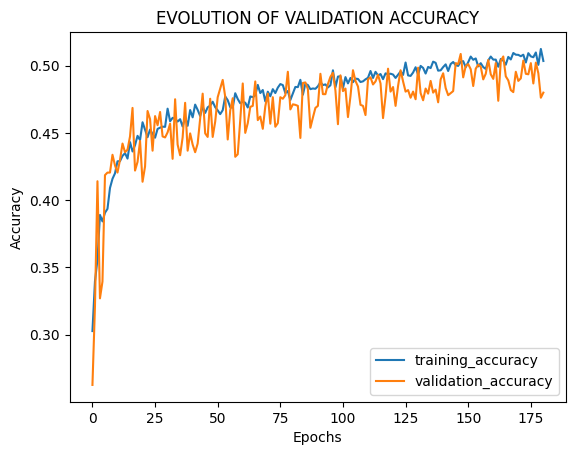

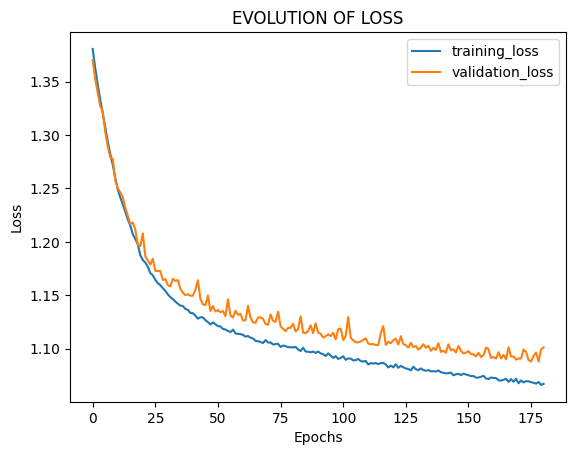

In [6]:
# Val acc. and Val loss evolution
plot_acc_loss(rn_model.fit)

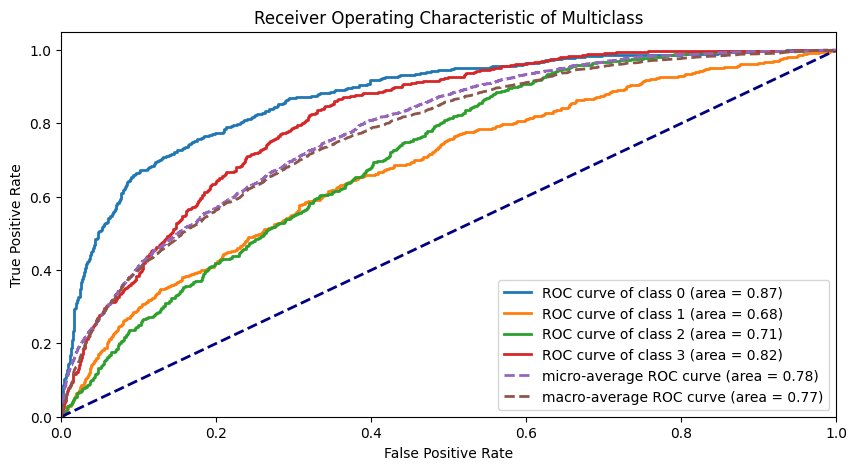

In [7]:
# ROC curves
plot_ROC(rn_model.predictions,basic_bundle.y_test_onehot,4)

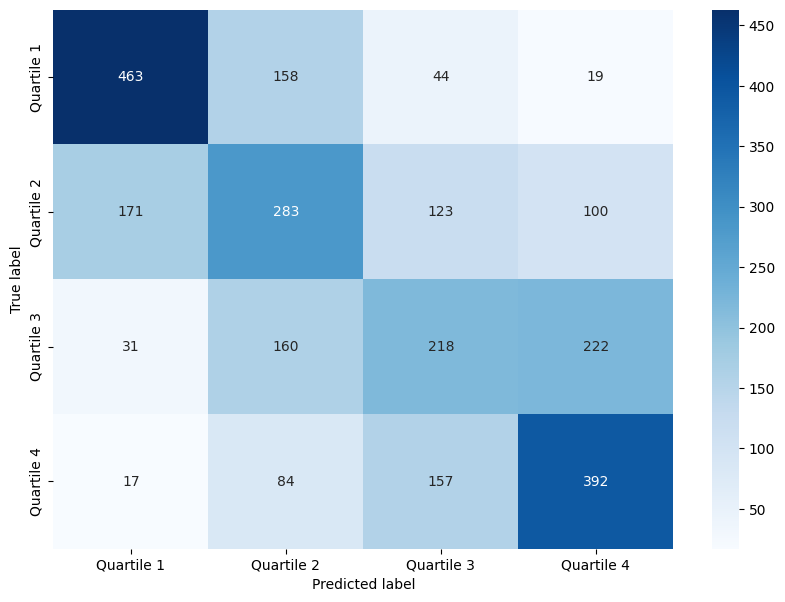

In [8]:
# Confusion matrix
plot_cm(basic_bundle.y_test_onehot,rn_model.predictions)

In [9]:
# Clasification report
print(classification_report(np.argmax(basic_bundle.y_test_onehot, axis=1), np.argmax(rn_model.predictions, axis=1)))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68       684
           1       0.41      0.42      0.42       677
           2       0.40      0.35      0.37       631
           3       0.53      0.60      0.57       650

    accuracy                           0.51      2642
   macro avg       0.51      0.51      0.51      2642
weighted avg       0.51      0.51      0.51      2642



In [ ]:
# 0.5

In [10]:
rn_model.save("/content/drive/MyDrive/Thesis/M224A-2111/rn50_hdi_224A_2111_v1.h5")